In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import pearsonr, spearmanr

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from keras.utils import Sequence
import h5py
import os

class MPRADataLoader(Sequence):
    def __init__(self, file_path, batch_size=32) :
        self.batch_size = batch_size
        self.fname = file_path

        with h5py.File(self.fname, 'r') as hf:
            self.max_batches = hf['X']['sequence'].shape[0]//self.batch_size

    def __len__(self):
        return self.max_batches

    def __getitem__(self, idx):
        start_idx = self.batch_size*idx
        end_idx = start_idx + self.batch_size
        with h5py.File(self.fname, 'r') as hf:
            x, y = hf['X']['sequence'][start_idx:end_idx], hf['Y']['output'][start_idx:end_idx]
       
        return x,y 

with h5py.File("../../../../seqprop/examples/mpradragonn/mpradragonn_traindata.hdf5", 'r') as hf:
    x_train, y_train = hf['X']['sequence'][:], hf['Y']['output'][:]

x_train = np.expand_dims(x_train, axis=1)
y_train = y_train[:, 11] - y_train[:, 5]

with h5py.File("../../../../seqprop/examples/mpradragonn/mpradragonn_testdata.hdf5", 'r') as hf:
    x_test, y_test = hf['X']['sequence'][:], hf['Y']['output'][:]

x_test = np.expand_dims(x_test, axis=1)
y_test = y_test[:, 11] - y_test[:, 5]

print(x_train.shape)
print(x_test.shape)

x_test_orig = np.copy(x_test)
y_test_orig = np.copy(y_test)


(914348, 1, 145, 4)
(10130, 1, 145, 4)


In [3]:
#Reconstruct sequences from pre-computed one-hot-coded matrices

use_cached_version = True

sequence_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

seqs_train = None
seqs_test = None

if use_cached_version :
    seqs_train = pd.read_csv("mpradragonn_seqs_train.csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("mpradragonn_seqs_test.csv", sep="\t")["seq"].values.tolist()
else :
    seqs_train = [sequence_encoder.decode(x_train[i, 0]) for i in range(x_train.shape[0])]
    seqs_test = [sequence_encoder.decode(x_test[i, 0]) for i in range(x_test.shape[0])]

    seqs_train_df = pd.DataFrame({'seq' : seqs_train})
    seqs_train_df.to_csv("mpradragonn_seqs_train.csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test})
    seqs_test_df.to_csv("mpradragonn_seqs_test.csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("len(seqs_test) = " + str(len(seqs_test)))


len(seqs_train) = 914348
len(seqs_test) = 10130


In [4]:
#Sort data in ascending order of ground truth fitness scores

use_cached_version = True

q = 1.0

n_train = 250000
n_test = 25000

n_total = n_train + n_test

if use_cached_version :
    seqs_train = pd.read_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_train_" + str(n_train) + ".csv", sep="\t")["seq"].values.tolist()
    seqs_test = pd.read_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_test_" + str(n_test) + ".csv", sep="\t")["seq"].values.tolist()
    y_train = np.ravel(pd.read_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_train_" + str(n_train) + ".csv", sep="\t")["y"].values)
    y_test = np.ravel(pd.read_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_test_" + str(n_test) + ".csv", sep="\t")["y"].values)
else :
    sort_index_train = np.argsort(y_train)

    seqs_train = [seqs_train[sort_index_train[i]] for i in range(len(seqs_train))]
    y_train = y_train[sort_index_train]

    y_q = np.quantile(y_train, q=q)

    seqs_qt = [seqs_train[i] for i in range(len(seqs_train)) if y_train[i] < y_q]
    y_qt = y_train[y_train < y_q]
    
    shuffle_index = np.arange(len(seqs_qt))
    np.random.shuffle(shuffle_index)
    
    seqs_qt = [seqs_qt[shuffle_index[i]] for i in range(len(seqs_qt))]
    y_qt = y_qt[shuffle_index]

    seqs_train = [seqs_qt[i] for i in range(n_train)]
    y_train = y_qt[:n_train]

    seqs_test = [seqs_qt[i] for i in range(n_train, n_train + n_test)]
    y_test = y_qt[n_train:n_train + n_test]
    
    seqs_train_df = pd.DataFrame({'seq' : seqs_train, 'y' : y_train})
    seqs_train_df.to_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_train_" + str(n_train) + ".csv", sep="\t", index=False)

    seqs_test_df = pd.DataFrame({'seq' : seqs_test, 'y' : y_test})
    seqs_test_df.to_csv("mpradragonn_hepg2_seqs_qt_" + str(q).replace(".", "_") + "_n_" + str(n_total) + "_test_" + str(n_test) + ".csv", sep="\t", index=False)

print("len(seqs_train) = " + str(len(seqs_train)))
print("y_train.shape = " + str(y_train.shape))

print("len(seqs_test) = " + str(len(seqs_test)))
print("y_test.shape = " + str(y_test.shape))


len(seqs_train) = 250000
y_train.shape = (250000,)
len(seqs_test) = 25000
y_test.shape = (25000,)


In [5]:
#Add measurement noise

noise = 0.0

y_train += np.random.normal(loc=0.0, scale=noise, size=y_train.shape)


In [6]:
#One-hot-encode data

encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})

onehot_train = [np.expand_dims(np.expand_dims(encoder(seqs_train[i]), axis=0), axis=0) for i in range(len(seqs_train))]
onehot_train = np.concatenate(onehot_train, axis=0)

onehot_test = [np.expand_dims(np.expand_dims(encoder(seqs_test[i]), axis=0), axis=0) for i in range(len(seqs_test))]
onehot_test = np.concatenate(onehot_test, axis=0)

print("onehot_train.shape = " + str(onehot_train.shape))
print("onehot_test.shape = " + str(onehot_test.shape))


onehot_train.shape = (250000, 1, 145, 4)
onehot_test.shape = (25000, 1, 145, 4)


In [7]:
#Define a simple dense network predictor on subsampled data (the weak predictor)

def neg_log_likelihood(y_true, y_pred) :
    y_true = y_true[:, 0]

    mean = y_pred[:, 0]
    variance = K.softplus(y_pred[:, 1]) + 1e-6

    log_variance = K.log(variance)

    return 0.5 * K.mean(log_variance, axis=-1) + 0.5 * K.mean(K.square(y_true - mean) / variance, axis=-1) + 0.5 * K.log(2 * np.pi)

def make_weak_oracle() :

    sequence_input = Input(shape=(1, 145, 4))

    #Define model layers

    conv_1 = Conv2D(32, (1, 8), padding='valid', activation='linear', name='weak_conv2d_1')
    batchnorm_1 = BatchNormalization(axis=-1, name='weak_batchnorm_1')
    relu_1 = Activation('relu')

    conv_2 = Conv2D(64, (1, 7), padding='valid', activation='linear', name='weak_conv2d_2')
    batchnorm_2 = BatchNormalization(axis=-1, name='weak_batchnorm_2')
    relu_2 = Activation('relu')

    max_pool_3 = MaxPooling2D(pool_size=(1, 4))

    flatten_3 = Flatten()
    dense_4 = Dense(64, activation='elu', name='weak_dense_1')

    final_dense = Dense(2, activation='linear', name='weak_dense_2')
    final_act = Activation("linear")

    #Execute functional model definition

    relu_1_out = relu_1(batchnorm_1(conv_1(sequence_input)))
    relu_2_out = relu_2(batchnorm_2(conv_2(relu_1_out)))

    max_pool_3_out = max_pool_3(relu_2_out)

    dense_4_out = dense_4(flatten_3(max_pool_3_out))

    final_dense_out = final_dense(dense_4_out)
    final_act_out = final_act(final_dense_out)

    conv_model = Model(
        [sequence_input],
        [final_act_out]
    )

    conv_model.compile(
        loss=neg_log_likelihood,
        #optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
        optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9)
    )
    
    return conv_model


In [ ]:
#Train conv model

n_models = 1
n_epochs = 25
batch_size = 32

for model_ix in range(n_models) :

    model_name = "mpradragonn_hepg2_weak_predictor_qt_" + str(q).replace(".", "_") + "_noise_" + str(noise).replace(".", "") + "_n_train_" + str(n_train) + "_n_models_" + str(n_models) + "_model_ix_" + str(model_ix)

    print("Training model '" + model_name + "'")
    
    conv_model = make_weak_oracle()
    
    callbacks =[
        EarlyStopping(
            monitor='val_loss',
            min_delta=1e-6,
            patience=5,
            verbose=True,
            restore_best_weights=True
        )
    ]

    train_history = conv_model.fit(
        [onehot_train],
        [y_train],
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(
            [onehot_test],
            [y_test]
        ),
        callbacks=callbacks
    )
    
    # Save model and weights
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name + '.h5')
    conv_model.save(model_path)
    print('Saved trained model at %s ' % model_path)


-- CNN Model (Training data) --
pearson-r correlation = 0.1184
pearson-r p = 0.0


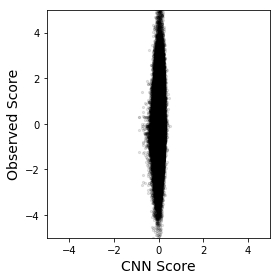

-- CNN Model (Test data) --
pearson-r correlation = 0.0611
pearson-r p = 0.0


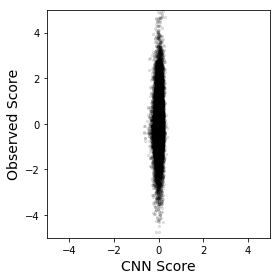

-- CNN Model (Full Test data) --
pearson-r correlation = 0.0572
pearson-r p = 0.0


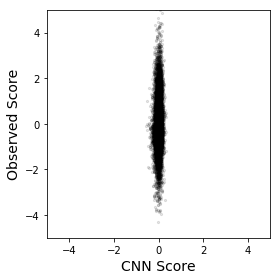

In [9]:
#Load and test models

n_models = 1

test_n_models = 1

save_dir = 'saved_models'

for model_ix in range(min(n_models, test_n_models)) :
    
    model_name = "mpradragonn_hepg2_weak_predictor_qt_" + str(q).replace(".", "_") + "_noise_" + str(noise).replace(".", "") + "_n_train_" + str(n_train) + "_n_models_" + str(n_models) + "_model_ix_" + str(model_ix)

    model_path = os.path.join(save_dir, model_name + '.h5')
    conv_model = load_model(model_path, custom_objects={'neg_log_likelihood' : lambda y_true, y_pred: y_pred})
    
    #Predict on subsampled training and test data
    print("-- CNN Model (Training data) --")

    y_train_hat = conv_model.predict(x=[onehot_train], batch_size=32)[:, 0]

    print("pearson-r correlation = " + str(round(pearsonr(y_train_hat, y_train)[0], 4)))
    print("pearson-r p = " + str(round(pearsonr(y_train_hat, y_train)[1], 4)))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_train_hat, y_train, s=5, color='black', alpha=0.1)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.xlabel("CNN Score", fontsize=14)
    plt.ylabel("Observed Score", fontsize=14)

    plt.tight_layout()
    plt.show()

    print("-- CNN Model (Test data) --")

    y_test_hat = conv_model.predict(x=[onehot_test], batch_size=32)[:, 0]

    print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test)[0], 4)))
    print("pearson-r p = " + str(round(pearsonr(y_test_hat, y_test)[1], 4)))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_test_hat, y_test, s=5, color='black', alpha=0.1)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.xlabel("CNN Score", fontsize=14)
    plt.ylabel("Observed Score", fontsize=14)

    plt.tight_layout()
    plt.show()
    
    #Predict on full test data
    print("-- CNN Model (Full Test data) --")

    y_test_hat = conv_model.predict(x=[x_test_orig], batch_size=32)[:, 0]

    print("pearson-r correlation = " + str(round(pearsonr(y_test_hat, y_test_orig)[0], 4)))
    print("pearson-r p = " + str(round(pearsonr(y_test_hat, y_test_orig)[1], 4)))

    f = plt.figure(figsize=(4, 4))

    plt.scatter(y_test_hat, y_test_orig, s=5, color='black', alpha=0.1)

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.xlabel("CNN Score", fontsize=14)
    plt.ylabel("Observed Score", fontsize=14)

    plt.tight_layout()
    plt.show()
